<a href="https://colab.research.google.com/github/ryeya/AIFactory/blob/main/%EB%A9%80%ED%8B%B0%EB%AA%A8%EB%8B%AC_%EC%84%BC%EC%84%9C_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EA%B8%B0%EB%B0%98_PFI_%EA%B8%B0%EB%B2%95%EC%9D%84_%ED%86%B5%ED%95%9C_%EC%A4%91%EC%9A%94_%ED%8A%B9%EC%A7%95_%EC%B6%94%EC%B6%9C_%EB%B0%8F_%EC%88%98%EB%A9%B4_%EC%9C%A0%ED%98%95_%EB%B6%84%EC%84%9D_%EC%97%B0%EA%B5%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
%matplotlib inline

In [ ]:
# data load
sleep = pd.read_csv('./user_sleep_2020.csv')
survey = pd.read_csv('./user_survey_2020.csv')

print(sleep.shape, survey.shape)

(615, 23) (1230, 17)


In [ ]:
# 사용자 정보 지우기
sleep = sleep.drop('timezone', axis=1)
sleep = sleep.drop('date', axis=1)
sleep = sleep.drop('startDt', axis=1)
sleep = sleep.drop('endDt', axis=1)
sleep = sleep.drop('lastUpdate', axis=1)

In [ ]:
# 데이터 column name 변경
def func(x):
  return x

sleep['dur_wakeup'] = sleep['durationtowakeup']
sleep['wakeup_dur'] = sleep['wakeupduration']  
sleep['dur_to_sleep'] = sleep['durationtosleep']
sleep['snoring_dur'] = sleep['snoring']
sleep['deep_dur'] = sleep['deepsleepduration']
sleep['rem_dur'] = sleep['remsleepduration']
sleep['light_dur'] = sleep['lightsleepduration']
sleep['breath'] = sleep['breathing_disturbances_intensity']

sleep = sleep.drop('durationtowakeup', axis=1)
sleep = sleep.drop('wakeupduration', axis=1)
sleep = sleep.drop('lightsleepduration', axis=1)
sleep = sleep.drop('deepsleepduration', axis=1)
sleep = sleep.drop('durationtosleep', axis=1)
sleep = sleep.drop('remsleepduration', axis=1)
sleep = sleep.drop('snoring', axis=1)
sleep = sleep.drop('breathing_disturbances_intensity', axis=1)


In [ ]:
# null값 확인
sleep.isnull().sum()

userId                 0
wakeupcount            0
hr_average             0
hr_min                 0
hr_max                 0
rr_average             0
rr_min                 0
rr_max                 0
snoringepisodecount    0
sleep_score            0
dur_wakeup             0
wakeup_dur             0
dur_to_sleep           0
snoring_dur            0
deep_dur               0
rem_dur                0
light_dur              0
breath                 0
dtype: int64

In [ ]:
# 중복값 확인
sleep.duplicated().sum()

0

In [ ]:
# survey이 am/pm으로 나눠져 있기 때문에 유효값들을 합치는 데이터 전처리 과정 
survey_2 = pd.DataFrame()

for column in survey.columns:
  if column in ["sleep","sleepProblem","dream","amCondition","amEmotion"]:
    column_value_list = []
    for i in range(615):
      column_value_list.append(survey.iloc[2*i][column])
    survey_2[column] = column_value_list

  elif column in ["pmEmotion","pmStress","pmFatigue","caffeine","cAmount(ml)","alcohol","aAmount(ml)"]:
    column_value_list = []
    for i in range(615):
      column_value_list.append(survey.iloc[2*i+1][column])
    survey_2[column] = column_value_list
  
survey_2.head()

,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,pmFatigue,caffeine,cAmount(ml),alcohol,aAmount(ml)
0,4.0,0.0,3.0,3.0,4.0,4.0,4.0,2.0,NaN,NaN,NaN,NaN
1,3.0,2.0,2.0,2.0,3.0,4.0,5.0,2.0,coffee,200.0,NaN,NaN
2,3.0,2.0,2.0,3.0,3.0,4.0,2.0,4.0,coffee,200.0,NaN,NaN
3,4.0,0.0,4.0,4.0,3.0,5.0,4.0,3.0,coffee,150.0,NaN,NaN
4,4.0,0.0,4.0,2.0,4.0,4.0,4.0,2.0,NaN,NaN,NaN,NaN


In [ ]:
# caffeine과 alcohol 섭취량이 아닌 여부로 데이터를 변환
survey_2 = survey_2.drop('caffeine', axis=1)
survey_2 = survey_2.drop('alcohol', axis=1)
survey_2['caffeine'] = survey_2['cAmount(ml)'].apply(lambda x: x if x > 0 else 0)
survey_2['alcohol'] = survey_2['aAmount(ml)'].apply(lambda x: x if x > 0 else 0)
survey_2 = survey_2.drop('cAmount(ml)', axis=1)
survey_2 = survey_2.drop('aAmount(ml)', axis=1)

In [ ]:
sleep['dream'] = survey_2['dream']
sleep['caffeine'] = survey_2['caffeine'].apply(lambda x: 1 if x > 0 else 0)
sleep['alcohol'] = survey_2['alcohol'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler

data = sleep[['breath', 'rem_dur', 'deep_dur', 'light_dur', 'rr_average', 'rr_min', 'dur_to_sleep', 'hr_max', 'hr_average', 'dur_wakeup', 'hr_min', 'dream', 'caffeine', 'alcohol', 'snoring_dur' ,'snoringepisodecount',  'wakeupcount', 'rr_max', 'wakeup_dur']]

# scaler = StandardScaler()   
# scaler = RobustScaler()
scaler = MinMaxScaler()

scaler.fit(data)
data_scaled = scaler.transform(data)

In [ ]:
# sleep의 중요 특징을 추출하기 위한 permutation feature importance model 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# from sklearn.inspection import permutation_importance 

x = pd.DataFrame(data_scaled, columns=data.columns)
y = sleep[['sleep_score']]
# y= sleep[['cluster']]
train_X, val_X, train_y, val_y = train_test_split(x, y, random_state=1)
my_model = RandomForestRegressor(n_estimators=100, random_state=0).fit(train_X, train_y)

<ipython-input-14-0db70c3ef191>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  my_model = RandomForestRegressor(n_estimators=100, random_state=0).fit(train_X, train_y)


In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
# eli5.show_weights(perm, feature_names = val_X.columns.tolist()) # Notebook에서 실행 가능
eli5.show_weights(perm, feature_names = x.columns.tolist())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107747 sha256=409bd99539a19cf0bd9b373fb2c3a1aad9f4693f0946ac46c5a5dc6e89c166c0
  Stored in directory: /root/.cache/pip/wheels/7b/26/a5/8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5


Weight,Feature
0.7189 ± 0.0830,breath
0.2584 ± 0.0457,rem_dur
0.1675 ± 0.0432,light_dur
0.1022 ± 0.0333,deep_dur
0.0101 ± 0.0057,wakeup_dur
0.0013 ± 0.0005,dur_to_sleep
0.0009 ± 0.0008,dream
0.0006 ± 0.0018,hr_average
0.0006 ± 0.0011,rr_average
0.0006 ± 0.0015,snoring_dur


In [ ]:
# xgboost model
import xgboost
from xgboost import XGBClassifier, XGBRegressor
from sklearn import metrics

xgb = XGBRegressor(random_state=0, n_estimators=300).fit(train_X, train_y)
perm = PermutationImportance(xgb, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = x.columns.tolist())

Weight,Feature
0.5741 ± 0.0878,breath
0.3094 ± 0.0521,rem_dur
0.2835 ± 0.0665,light_dur
0.1572 ± 0.0514,deep_dur
0.0083 ± 0.0033,wakeup_dur
0.0017 ± 0.0033,rr_min
0.0015 ± 0.0034,wakeupcount
0.0013 ± 0.0030,hr_average
0.0010 ± 0.0012,rr_average
0.0004 ± 0.0008,caffeine


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

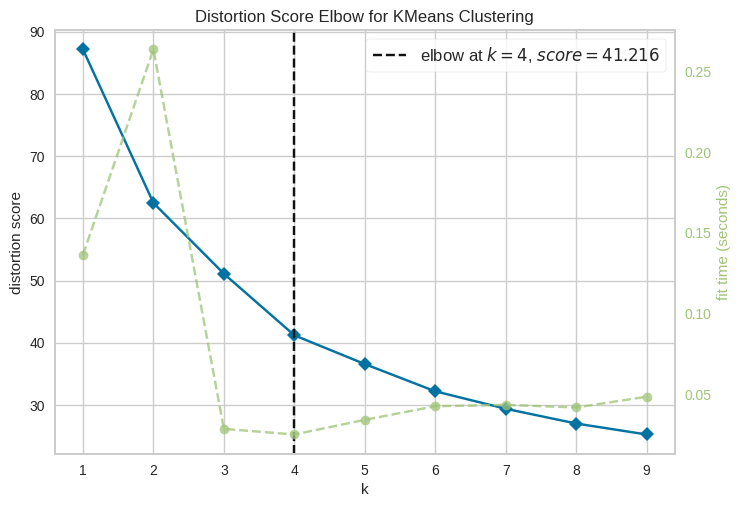

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

#  'sleep_score',  'rr_average', 'rr_min', 'dur_to_sleep', 'hr_max', 'hr_average', 'sleep_satisfaction', 'dur_wakeup', 'hr_min', 'dream', 'caffeine', 'alcohol', 'snoring_dur' ,'snoringepisodecount',  'wakeupcount', 'rr_max'
data = sleep[['breath', 'rem_dur', 'deep_dur', 'light_dur','wakeup_dur']]

scaler = MinMaxScaler()
scaler.fit(data)
data_scaled = scaler.transform(data)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10), timing=True)
visualizer.fit(data_scaled)
visualizer.show()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


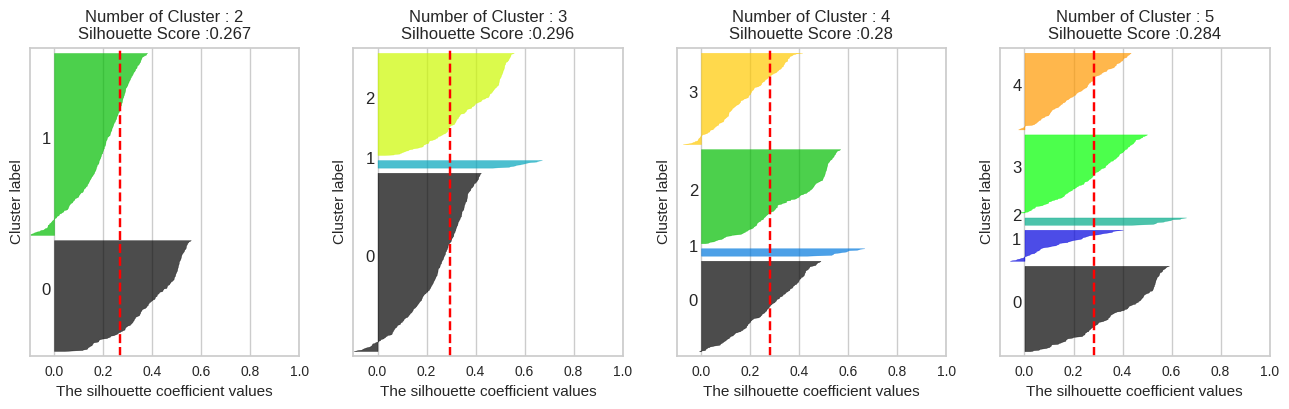

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


def visualize_silhouette(cluster_lists, X_features):     
    n_cols = len(cluster_lists)
    
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    for ind, n_cluster in enumerate(cluster_lists):
        
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

visualize_silhouette([2, 3, 4, 5], data_scaled)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# # data = sleep[['dur_wakeup',	'wakeup_dur', 'rem_dur', 'rr_average', 'hr_average', 'snoringepisodecount', 'sleep_score', 'breath', 'wakeupcount']]
# data = sleep[['wakeupcount', 'hr_average', 'hr_min', 'hr_max', 'rr_average', 'rr_min', 'rr_max', 'snoringepisodecount', 'sleep_score', 'dur_wakeup', 'wakeup_dur', 'light_dur', 'deep_dur', 'dur_to_sleep', 'rem_dur', 'snoring_dur', 'breath']]
# scaler_ = MinMaxScaler()
# scaler_.fit(data)
# data_scaled_ = scaler_.transform(data)

# K-Means model, n_clusters=K
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
sleep['cluster']=clusters

# 2차원으로 축소 
n_components = 2

# T-SNE model
model = TSNE(n_components=n_components, learning_rate=200)
X_embedded = model.fit_transform(data_scaled)


In [ ]:
new_clusters = []
for c in clusters:
  if c == 0:
    new_clusters.append("$k=1$")
  elif c == 1:
    new_clusters.append("$k=2$")
  elif c == 2:
    new_clusters.append("$k=4$")
  elif c == 3:
    new_clusters.append("$k=3$")
  
new_clusters

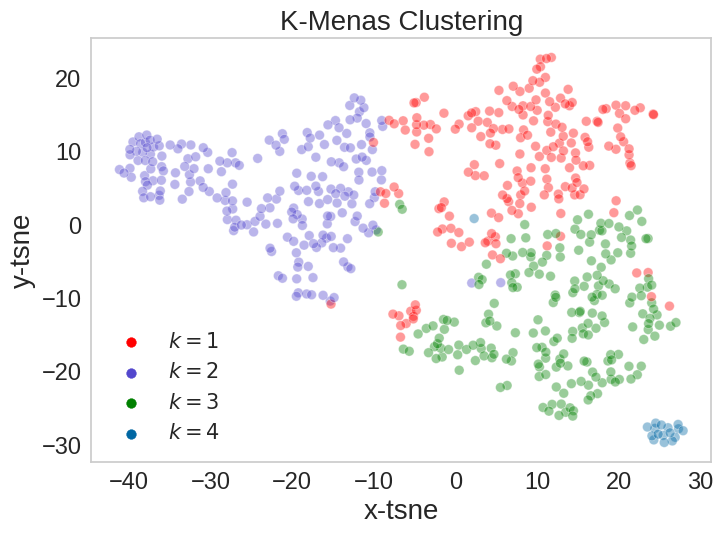

In [ ]:
colors = ["#ff0000", "#5347CD", "#008000", "#0067A3"]
palette = sns.color_palette(colors, len(set(new_clusters)))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=new_clusters, legend='full', palette=palette, alpha=0.4)
plt.grid(False)
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=17)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=17)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=15)  # 범례 폰트 크기
plt.ylabel('y-tsne')
plt.xlabel('x-tsne')
plt.grid(False)
plt.title('K-Menas Clustering', fontsize=20)
plt.show()

In [ ]:
sleep_data = pd.DataFrame(data_scaled, columns=data.columns)

In [ ]:
sleep_data['cluster'] = sleep['cluster']
sleep_data['sleep_score'] = sleep['sleep_score']

cluster0 = sleep_data[sleep_data['cluster']==0]
cluster1 = sleep_data[sleep_data['cluster']==1]
cluster2 = sleep_data[sleep_data['cluster']==3]
cluster3 = sleep_data[sleep_data['cluster']==2]

In [ ]:
# 각 유형별로 sleep_score의 평균을 계산하기
breath_clu=[]
breath_clu.append(cluster0['breath'].mean())
breath_clu.append(cluster1['breath'].mean())
breath_clu.append(cluster2['breath'].mean())
breath_clu.append(cluster3['breath'].mean())

rem_dur_clu=[]
rem_dur_clu.append(cluster0['rem_dur'].mean())
rem_dur_clu.append(cluster1['rem_dur'].mean())
rem_dur_clu.append(cluster2['rem_dur'].mean())
rem_dur_clu.append(cluster3['rem_dur'].mean())

light_dur_clu=[]
light_dur_clu.append(cluster0['light_dur'].mean())
light_dur_clu.append(cluster1['light_dur'].mean())
light_dur_clu.append(cluster2['light_dur'].mean())
light_dur_clu.append(cluster3['light_dur'].mean())

deep_dur_clu=[]
deep_dur_clu.append(cluster0['deep_dur'].mean())
deep_dur_clu.append(cluster1['deep_dur'].mean())
deep_dur_clu.append(cluster2['deep_dur'].mean())
deep_dur_clu.append(cluster3['deep_dur'].mean())

sleep_score_clu=[]
sleep_score_clu.append(cluster0['sleep_score'].mean())
sleep_score_clu.append(cluster1['sleep_score'].mean())
sleep_score_clu.append(cluster2['sleep_score'].mean())
sleep_score_clu.append(cluster3['sleep_score'].mean())

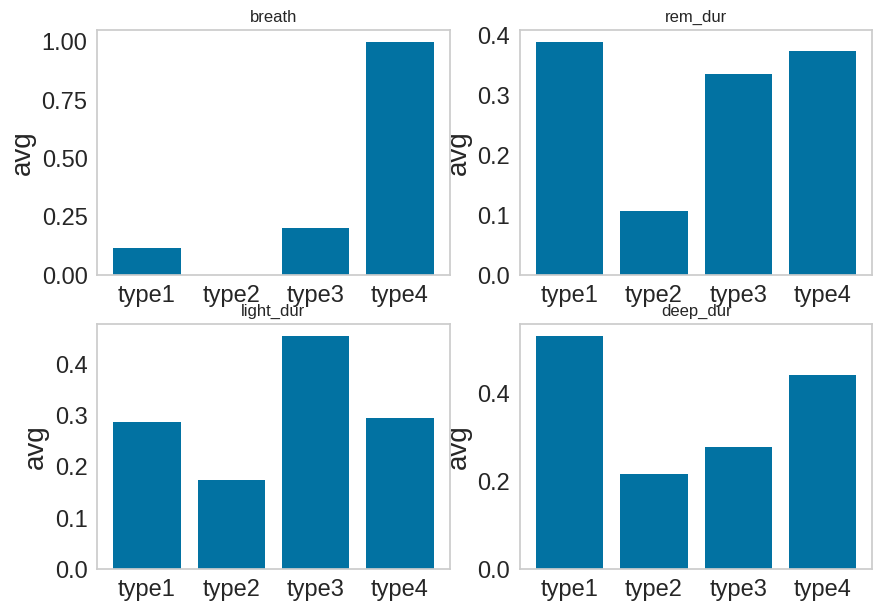

In [ ]:
# importance feature 시각화(sleep_score, snoring_dur, breath)

features = [breath_clu, rem_dur_clu, light_dur_clu, deep_dur_clu]
titles = ['breath', 'rem_dur', 'light_dur', 'deep_dur']
fig = plt.figure(figsize=(10, 7)) 
ax0 = fig.add_subplot(2, 2, 1) # 서브플롯들을 2 x 2 배열로 배치 그중 첫번째
ax1 = fig.add_subplot(2, 2, 2) 
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)
axs = [ax0, ax1, ax2, ax3]

for i in range(len(features)):
  axs[i].bar(x=range(len(features[i])), height=features[i], tick_label=['type1', 'type2', 'type3', 'type4'])
  axs[i].set_ylabel('avg')
  # axs[i].set_xlabel('type')
  axs[i].grid(False)
  axs[i].set_title(titles[i])
plt.show()

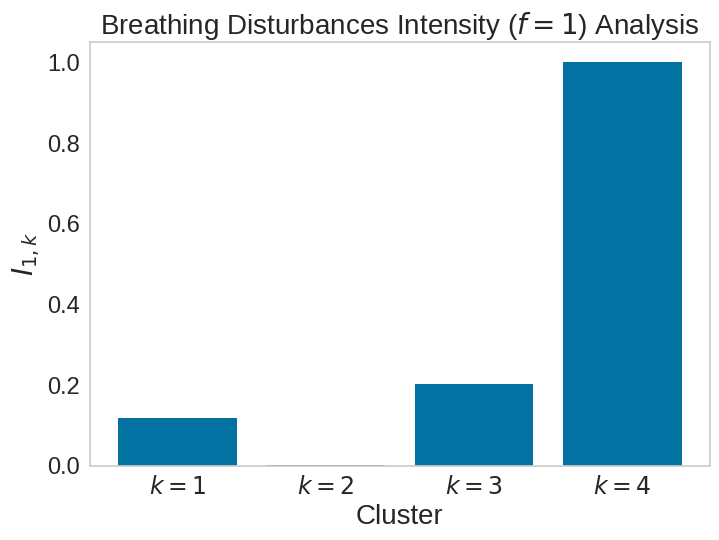

In [ ]:
plt.bar(x=range(len(breath_clu)), height=breath_clu, tick_label=['$k=1$', '$k=2$', '$k=3$', '$k=4$'])

plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=17)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=17)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=15)  # 범례 폰트 크기
plt.ylabel('$I_{1,k}$')
plt.xlabel('Cluster')
plt.grid(False)
plt.title('Breathing Disturbances Intensity ($f=1$) Analysis', fontsize=20)
plt.show()

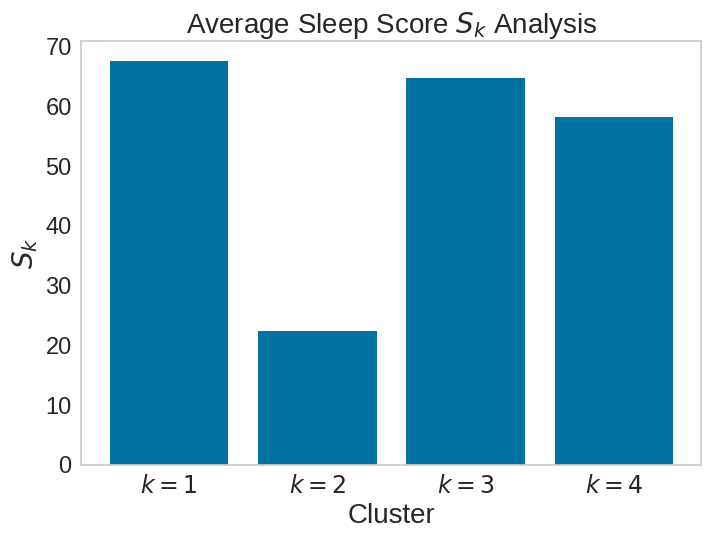

In [ ]:
plt.bar(x=range(len(sleep_score_clu)), height=sleep_score_clu, tick_label=['$k=1$', '$k=2$', '$k=3$', '$k=4$'])

plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=17)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=17)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=15)  # 범례 폰트 크기
plt.ylabel('$S_k$')
plt.xlabel('Cluster')
plt.grid(False)
plt.title('Average Sleep Score $S_k$ Analysis', fontsize=20)
plt.show()

In [ ]:
cycle_type1 = [rem_dur_clu[0], light_dur_clu[0], deep_dur_clu[0]]
cycle_type2 = [rem_dur_clu[1], light_dur_clu[1], deep_dur_clu[1]]
cycle_type3 = [rem_dur_clu[2], light_dur_clu[2], deep_dur_clu[2]]
cycle_type4 = [rem_dur_clu[3], light_dur_clu[3], deep_dur_clu[3]]

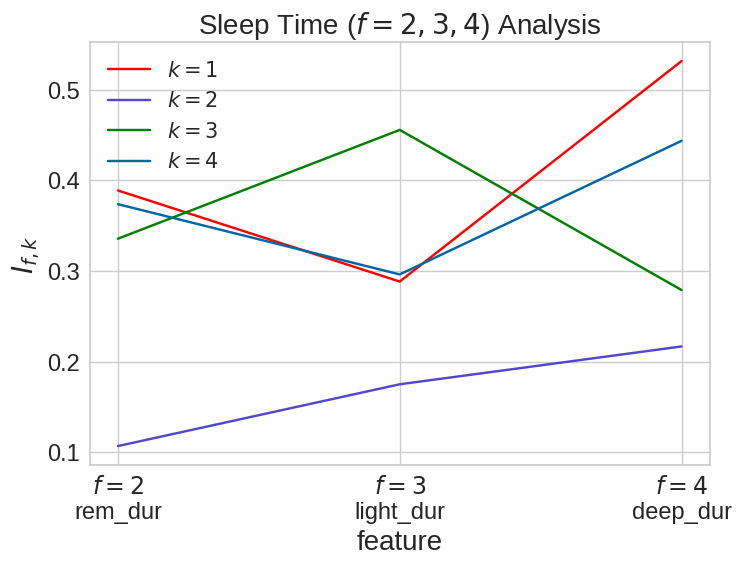

In [ ]:
plt.plot(['$f=2$\nrem_dur', '$f=3$\nlight_dur', '$f=4$\ndeep_dur'], cycle_type1, '#ff0000', label='$k=1$')
plt.plot(['$f=2$\nrem_dur', '$f=3$\nlight_dur', '$f=4$\ndeep_dur'], cycle_type2, '#5347CD', label='$k=2$')
plt.plot(['$f=2$\nrem_dur', '$f=3$\nlight_dur', '$f=4$\ndeep_dur'], cycle_type3, '#008000', label='$k=3$')
plt.plot(['$f=2$\nrem_dur', '$f=3$\nlight_dur', '$f=4$\ndeep_dur'], cycle_type4, '#0067A3', label='$k=4$')

plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=17)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=17)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=15)  # 범례 폰트 크기
plt.ylabel('$I_{f,k}$')
plt.xlabel('feature')
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Sleep Time ($f=2, 3, 4$) Analysis', fontsize=20)
plt.show()